In [1]:
import numpy as np
import pandas as pd
import math
import random
import matplotlib.pyplot as plt

## Create the toy datasets

In [2]:
np.random.seed(0)

In [3]:
def generate_polynomial_dataset(coeffs, width, samples, samples_on_edge):
    def _calculate_value(x_i):
        return np.sum(np.multiply(np.power(np.repeat(x_i, len(coeffs)), range(len(coeffs))), coeffs))
    
    x = np.linspace(-10, 10, 100)
    boundary = [_calculate_value(x_i) for x_i in x]
    margin_1 = [b + width for b in boundary]
    margin_2 = [b - width for b in boundary] 
    
    plt.plot(x, boundary, 'r')
    plt.plot(x, margin_1, 'r', alpha = 0.3)
    plt.plot(x, margin_2, 'r', alpha = 0.3)
    
    # Generate observations on the edge of the margin
    x_1 = []
    while len(x_1) < samples_on_edge:
        value = np.random.uniform(-10, 10)
        x_1.append([value, _calculate_value(value) + width])
    value = np.random.uniform(-10, 10)
    x_2 = [[value, _calculate_value(value) - width]]
    # Generate the rest of the observations
    while len(x_1) < samples or len(x_2) < samples:
        value_x = np.random.uniform(-10, 10)
        value_y = np.random.uniform(min(margin_2), max(margin_1))
        if value_y > _calculate_value(value_x) + width:
            x_1.append([value_x, value_y])
        elif value_y < _calculate_value(value_x) - width:
            x_2.append([value_x, value_y])

    # Output label
    y = np.concatenate((np.repeat(0, len(x_1)), np.repeat(1, len(x_2))))

    # Final version of the dataset
    x_1.extend(x_2)
    dataset = np.array(x_1)
    dataset = np.concatenate((dataset, y[:, None]), axis = 1)

    _ = plt.plot(dataset[np.where(dataset[:, 2] == 0), 0], 
                 dataset[np.where(dataset[:, 2] == 0), 1], 
                 'o',
                 color = 'tab:blue')
    _ = plt.plot(dataset[np.where(dataset[:, 2] == 1), 0], 
                 dataset[np.where(dataset[:, 2] == 1), 1],
                 'o',
                 color = 'tab:orange')
    
    return dataset

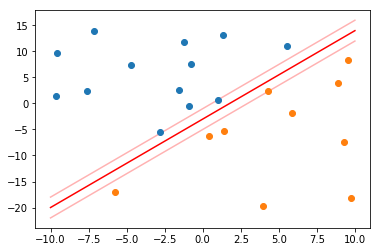

In [4]:
dataset_1 = generate_polynomial_dataset([-3, 1.7], 2, 10, 1)

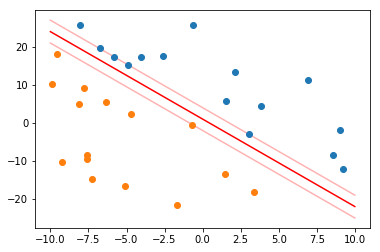

In [5]:
dataset_2 = generate_polynomial_dataset([1, -2.3], 3, 15, 4)

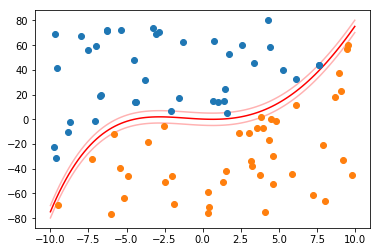

In [6]:
dataset_3 = generate_polynomial_dataset([0.2, -0.5, 0.3, 0.08, -0.003], 5, 40, 4)

In [7]:
def generate_gaussian_dataset(params, width, samples, samples_on_edge):
    # Not really gaussian data, but a toydataset design to be 
    # used with a RBF kernel
    x = np.linspace(-10, 10, 500)
    y = np.linspace(-10, 10, 500)
    xv, yv = np.meshgrid(x, y)
    
    @np.vectorize
    def border(x, y, w):
        close = []
        border = []
        for p in range(len(params)):
            dist = math.sqrt((params[p][0] - x) ** 2 + (params[p][1] - y) ** 2)
            close.append(dist < params[p][2] - w)
            border.append(dist == params[p][2] - w)
        if np.any(border) and np.all(np.logical_not(close)):
            return 0
        elif np.any(close):
            return 1
        else:
            return -1
    
    plt.contour(xv, yv, border(xv, yv, 0), levels = [0], colors = ['r'])
    c = plt.contour(xv, yv, border(xv, yv, width), levels = [0], colors = ['r'], alpha = 0.3)
    plt.contour(xv, yv, border(xv, yv, -width), levels = [0], colors = ['r'], alpha = 0.3)
    
    x_1 = []
    for i in range(len(c.collections[0].get_paths())):
        v = c.collections[0].get_paths()[i].vertices
        indices = list(range(v.shape[0]))
        np.random.shuffle(indices)
        x_1.extend([[v[j, 0], v[j, 1]] for j in indices[:samples_on_edge]])
    x_2 = [] 
    while len(x_1) < samples and len(x_2) < samples:
        value_x = np.random.uniform(-10, 10)
        value_y = np.random.uniform(-10, 10)
        close = False
        margin = False
        for p in range(len(params)):
            dist = math.sqrt((params[p][0] - value_x) ** 2 + (params[p][1] - value_y) ** 2)
            if dist < params[p][2]:
                close = True
            if dist > params[p][2] - width and dist < params[p][2] + width:
                margin = True
        if not margin:
            if close:
                x_1.append([value_x, value_y])
            else:
                x_2.append([value_x, value_y])
            
     # Output label
    y = np.concatenate((np.repeat(0, len(x_1)), np.repeat(1, len(x_2))))

    # Final version of the dataset
    x_1.extend(x_2)
    dataset = np.array(x_1)
    dataset = np.concatenate((dataset, y[:, None]), axis = 1)

    _ = plt.plot(dataset[np.where(dataset[:, 2] == 0), 0], 
                 dataset[np.where(dataset[:, 2] == 0), 1], 
                 'o',
                 color = 'tab:blue')
    _ = plt.plot(dataset[np.where(dataset[:, 2] == 1), 0], 
                 dataset[np.where(dataset[:, 2] == 1), 1],
                 'o',
                 color = 'tab:orange')
    
    return dataset

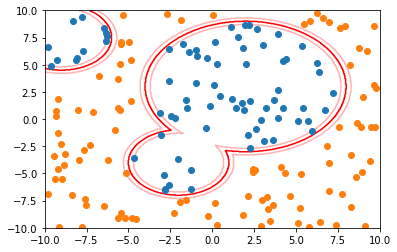

In [8]:
params = [[2, 3, 6],
          [-2, -4, 3],
          [-9, 7.5, 3]]

dataset_4 = generate_gaussian_dataset(params, 0.3, 100, 5)

## Sequential minimal optimisation

This is an implementation of Platt's paper: "Sequential Minimal Optimisation: a fast algorithm for training Support Vector machines".

I am simplifying my implementation by not implementing an error cache. 

In [9]:
class SMO:
    def __init__(self, X, y, C, tol = 0.01, eps = 0.01):
        self.X = X
        self.y = y
        self.C = C
        self.tol = tol
        self.eps = eps
        
    def _svm_output(self, x):
        u = 0
        for i in range(self.X.shape[0]):
            u = u + self.y[i] * self.alpha[i] * np.dot(self.X[i, :], x)
        return u - self.b
        
    def _objective_function(self):
        psi = 0
        for i in range(self.X.shape[0]):
            for j in range(self.X.shape[0]):
                psi = psi + self.y[i] * self.y[j] * np.dot(self.X[i, :], self.X[j, :]) * self.alpha[i] * self.alpha[j]

        return psi - np.sum(self.alpha)

    def _take_step(self, i1, i2, E2, alph2):
        if i1 == i2:
            return 0

        alph1 = self.alpha[i1]
        y1 = self.y[i1]
        y2 = self.y[i2]
        E1 = self._svm_output(self.X[i1, :]) - y1
        s = y1 * y2

        # compute L, H via equations (13) and (14)
        if y1 != y2:
            L = max(0, alph2 - alph1)
            H = min(self.C, self.C + alph2 - alph1)
        else:
            L = max(0, alph2 + alph1 - self.C)
            H = min(self.C, alph2 + alph1)
        if L == H:
            return 0

        k11 = np.dot(self.X[i1, :], self.X[i1, :])
        k12 = np.dot(self.X[i1, :], self.X[i2, :])
        k22 = np.dot(self.X[i2, :], self.X[i2, :])
        eta = k11 + k22 - 2 * k12

        if eta > 0:
            a2 = alph2 + y2 * (E1 - E2) / eta
            if a2 < L:
                a2 = L
            elif a2 > H:
                a2 = H
        else:
            prev_alph2 = alpha[i2]
            self.alpha[i2] = L
            L_obj = self._objective_function()
            self.alpha[i2] = H
            H_obj = self._objective_function()
            self.alpha[i2] = prev_alph2

            if L_obj < H_obj - self.eps:
                a2 = L
            elif L_obj > H_obj + self.eps:
                a2 = H
            else:
                a2 = alph2

        if math.fabs(a2 - alph2) < self.eps * (a2 + alph2 + self.eps):
            return 0

        a1 = alph1 + s * (alph2 - a2)

        # Update threshold to reflect chang in lagrance multipliers
        new_b1 = E1 + y1 * (a1 - self.alpha[i1]) * k11 + y2 * (a2 - self.alpha[i2]) * k12 + self.b
        new_b2 = E2 + y1 * (a1 - self.alpha[i1]) * k12 + y2 * (a2 - self.alpha[i2]) * k22 + self.b

        if a1 > L and a1 < H:
            self.b = new_b1
        elif a2 > L and a2 < H:
            self.b = new_b2
        else:
            self.b = (new_b1 + new_b2) / 2.0
            
        if a1 > L and a1 < H and a2 > L and a2 < H:
            print(new_b1 == new_b2)

        self.alpha[i1] = a1
        self.alpha[i2] = a2

        return 1

    def _examine_example(self, i2):
        y2 = self.y[i2]
        alph2 = self.alpha[i2]
        E2 = self._svm_output(self.X[i2, :]) - y2
        r2 = E2 * y2

        if (r2 < -self.tol and alph2 < self.C) or (r2 > self.tol and alph2 > 0):
            if np.sum(np.logical_and(self.alpha != 0, self.alpha != self.C)) > 1:
                # i1 chosen among the indices that violate the KKT conditions
                i1 = random.randint(0, len(self.alpha) - 1)
                loop = 0
                while loop < len(self.alpha):
                    if (self.alpha[i1] == 0 and self.y[i1] * self._svm_output(self.X[i1, :]) < 1) or \
                       (self.alpha[i1] > 0 and self.alpha[i1] < self.C and self._svm_output(self.X[i2, :]) != 1) or \
                       (self.alpha[i1] == self.C and self.y[i1] * self._svm_output(self.X[i1, :]) > 1):
                            if self._take_step(i1, i2, E2, alph2):
                                return 1

                    loop = loop + 1
                    i1 = (i1 + 1) % len(self.alpha)

            # Loop over all non-zero and non-C alpha, starting at a randompoint
            indices = np.where(np.logical_and(self.alpha != 0, self.alpha != self.C))[0]
            if len(indices) > 0:
                i = random.randint(0, len(indices) - 1)
                loop = 0
                while loop < len(indices):
                    i1 = indices[i]
                    if self._take_step(i1, i2, E2, alph2):
                        return 1

                    loop = loop + 1
                    i = (i + 1) % len(indices)        

            # Loop over all possible i1, starting at a random point
            i1 = random.randint(0, len(self.alpha) - 1)
            loop = 0
            while loop < len(self.alpha):
                if self._take_step(i1, i2, E2, alph2):
                    return 1

                loop = loop + 1
                i1 = (i1 + 1) % len(self.alpha)

        return 0
        
    def fit(self):
        # Alphas have to be initialised to zero: 
        # https://stats.stackexchange.com/questions/363952/why-do-svms-using-smo-algorithm-work-only-when-the-initial-values-of-the-multipl
        self.alpha = np.zeros(self.X.shape[0], )
        self.b = 0

        num_changed = 0
        examine_all = 1
        while num_changed > 0 or examine_all:
            num_changed = 0
            if examine_all:
                for i in range(self.X.shape[0]):
                    num_changed = num_changed + self._examine_example(i)
            else:
                for i in range(self.X.shape[0]):
                    if self.alpha[i] != 0 and self.alpha[i] != self.C:
                        num_changed = num_changed + self._examine_example(i)
            if examine_all == 1:
                examine_all = 0
            elif num_changed == 0:
                examine_all = 1 
                
    def predict(self, X_test):
        y = []
        for i in range(X_test.shape[0]):
            y.append(int(self._svm_output(X_test[i, :]) > 0))
        return y

In [10]:
def plot_predictions(dataset, smo):
    fig, ax = plt.subplots()
    
    _ = ax.plot(dataset[np.where(dataset[:, 2] == 0), 0], 
                 dataset[np.where(dataset[:, 2] == 0), 1], 
                 'o',
                 color = 'tab:blue')
    _ = ax.plot(dataset[np.where(dataset[:, 2] == 1), 0], 
                 dataset[np.where(dataset[:, 2] == 1), 1],
                 'o',
                 color = 'tab:orange')
    
    y_lim = ax.get_ylim()
    yy = list(np.linspace(y_lim[0], y_lim[1], 100))
    x_lim = ax.get_xlim()
    xx = list(np.linspace(x_lim[0], x_lim[1], 100))
    
    colormap = plt.cm.RdYlBu
    res = np.zeros((len(xx), len(yy)))
    for i in range(len(yy)):
        for j in range(len(xx)):
            x_test = np.array([xx[j], yy[i]]).reshape(-1, 1).T
            res[i, j] = smo.predict(x_test)[0]
    ext = [x_lim[0], x_lim[1], y_lim[0], y_lim[1]]
    ax.imshow(res, zorder = 0, extent = ext, alpha = 0.5, cmap = colormap, origin = 'lower', aspect = 'auto')

In [11]:
def test_svm(dataset):
    smo = SMO(X = dataset[:, :2], y = dataset[:, 2], C = 1)
    smo.fit()
    print(smo.alpha)
    plot_predictions(dataset, smo)

True
True
False
False
False
False
False
False
False
False
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.32981864e-01  0.00000000e+00 -5.20417043e-18
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  3.01273870e-02  0.00000000e+00  0.00000000e+00]


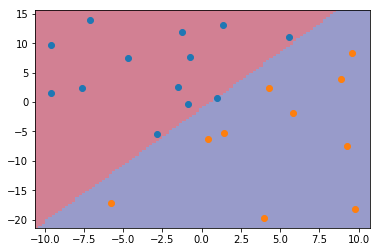

In [12]:
test_svm(dataset_1)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
True
False
False
False
False
False
False
False
True
False
False
False
False
True
False
False
False
False
False
False
True
True
False
True
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.36700536 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00448528 0.         0.0076028  0.         0.        ]


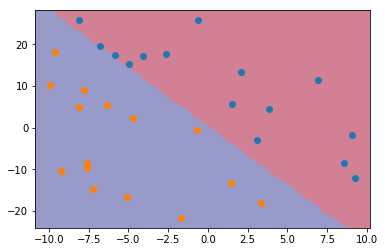

In [13]:
test_svm(dataset_2)

False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
True
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
True
False
False
False
False
False
False
False
False
True
False
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
True
False
False
False


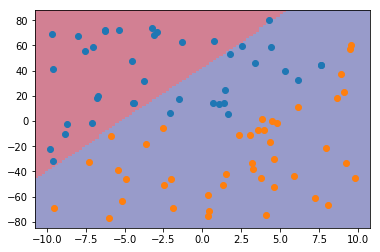

In [14]:
test_svm(dataset_3)

False
False
True
True
False
False
True
True
True
False
True
False
False
False
True
True
True
False
False
True
False
False
True
False
False
False
False
True
False
False
False
False
True
True
True
True
False
False
False
False
False
True
False
True
True
False
False
True
False
True
False
False
True
True
False
False
False
False
False
False
True
False
False
False
True
False
False
False
False
False
False
True
False
False
True
False
False
False
True
False
True
False
True
False
True
False
False
False
False
False
False
True
False
False
False
False
True
True
False
False
True
True
False
False
False
False
False
False
True
False
False
False
True
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
True
False
False
False
False
False
True
False
False
False
True
True
False
False
False
False
False
True
True
False
True
False
False
False
False
True
True
False
False
False
False
False
True
False
False
False
True
False
False
False
F

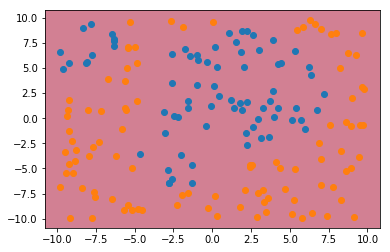

In [15]:
test_svm(dataset_4)

In [16]:
# TODO: which ones are the support vectors? plot alpha?

In [17]:
# TODO: replace all np.dot(a, b) by kernel(a, b)